# End to End Medial Diagnostic Use Case 

Steps of the project:
0. Create a virtual environment with python=3.8.13
1. Import and view the data 
2. Check the data for Sanity
3. Perform EDA on data set 
4. Preprocess the data for modelling
5. Fit and Evlaute various Models
6. Optimize the chosen model
7. Interpret the optimized model
8. Pickle and save the model as a pipeline
9. Deploy the model pipeline in streamlit
10. Scale model to cloud using git and streamlit sharing
    

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install xgboost

In [3]:
!pip install shap

In [4]:
# Load all the librarires
# for data manipulation and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# preprocessing modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# modelling modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# modules for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

#for model interpretation
import shap

# deployment module
#import streamlit as st

print("All Libraries are imported")


All Libraries are imported


### 1. Import and view the data 

In [5]:
data=pd.read_csv('data.csv')

In [6]:
data.head()

Unnamed: 0  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0           0            6      148             72             35        0   
1           1            1       85             66             29        0   
2           2            8      183             64              0        0   
3           3            1       89             66             23       94   
4           4            0      137             40             35      168   

    BMI  DiabetesPedigreeFunction  Age Outcome  
0  33.6                     0.627   50     Yes  
1  26.6                     0.351   31      No  
2  23.3                     0.672   32     Yes  
3  28.1                     0.167   21      No  
4  43.1                     2.288   33     Yes

In [7]:
data.shape


(768, 10)

###  Check the data for Sanity

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                768 non-null    int64  
 1   Pregnancies               768 non-null    int64  
 2   Glucose                   768 non-null    int64  
 3   BloodPressure             768 non-null    int64  
 4   SkinThickness             768 non-null    int64  
 5   Insulin                   768 non-null    int64  
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    int64  
 9   Outcome                   768 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 60.1+ KB


In [9]:
data.isnull().sum()

Unnamed: 0                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
data.describe().T

count        mean         std     min        25%  \
Unnamed: 0                768.0  383.500000  221.846794   0.000  191.75000   
Pregnancies               768.0    3.845052    3.369578   0.000    1.00000   
Glucose                   768.0  120.894531   31.972618   0.000   99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000   62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000    0.00000   
Insulin                   768.0   79.799479  115.244002   0.000    0.00000   
BMI                       768.0   31.992578    7.884160   0.000   27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078    0.24375   
Age                       768.0   33.240885   11.760232  21.000   24.00000   

                               50%        75%     max  
Unnamed: 0                383.5000  575.25000  767.00  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00

In [11]:
# check for any other non real characters
data[~data.applymap(np.isreal).any(1)]

Empty DataFrame
Columns: [Unnamed: 0, Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []

**Observations**
1. Data set has 768 rows and 10 columns( 1 redundant)
2. Dataset has no direct nulls but has nulls imputed as 0
3. Dataset has only 1 categorical variable the Outcome


In [12]:
data.columns

Index(['Unnamed: 0', 'Pregnancies', 'Glucose', 'BloodPressure',
       'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'Outcome'],
      dtype='object')

In [13]:
# drop the redundant column
data=data.drop('Unnamed: 0', axis=1)

In [14]:
# treat the nulls
zerofiller=lambda x: x.replace(0, x.median())
cols=data.columns[1:6]
data[cols]=data[cols].apply(zerofiller, axis=0)

In [15]:
#encode categoricals
df=data.copy()
d={'Yes':1, 'No':0}
df['Outcome']=df['Outcome'].map(d)

In [16]:
df.head(2)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35     30.5  33.6   
1            1       85             66             29     30.5  26.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0

### Perform EDA on data set 
1. UNIVARIATES- NUMERICALS
2. UNIVARIATES-CATEGORICALS
3. BIVARIATES-NUMERICAL vs CATEGORICAL
4. BIVARIATES- NUMERICALS VS NUMERICLAS
5. MULTIVARIATE CHARTS 
6. Correlations and Heatmaps 

##### 1. UNIVARIATES

In [17]:
def histograms(data):
    print('Univariate Histogram')
    data.hist()
    plt.tight_layout()
    plt.show()
    

Univariate Histogram


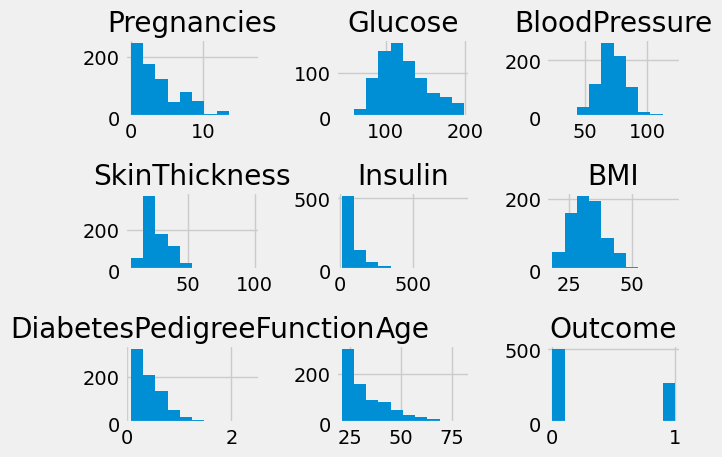

In [18]:
histograms(df)

In [19]:
def barchart(data, feature):
    print("Barchart of Categoricals")
    ax=sns.countplot(data=data, x=feature, color='green')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
    plt.show()

Barchart of Categoricals


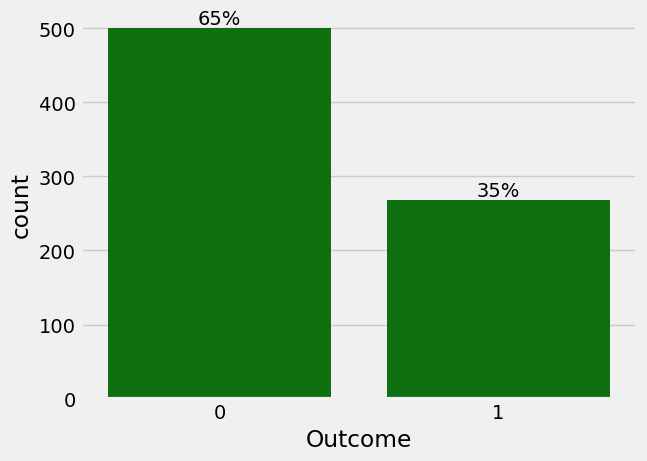

In [20]:
barchart(data=df, feature='Outcome')

**Observations**
Outcome variable is highly imbalanced. We need to solve for data imbalance 

In [21]:
def boxpolot_histplot(data, feature, figsize=(12,7), bins=None):
    print("Univariates of ", feature)
    fig, (ax_box, ax_hist)=plt.subplots(
    nrows=2,
    sharex=True,
    gridspec_kw={'height_ratios':(0.25,0.75)},
    figsize=figsize)
    
    sns.boxplot(data=data,x=feature, showmeans=True, ax=ax_box, color='violet')
    
    sns.histplot(data=data, x=feature, bins=bins, ax=ax_hist, pallete='winter') if bins else\
         sns.histplot(data=data,x=feature, ax=ax_hist)
    plt.axvline(data[feature].mean(),linestyle='--', color='green')
    plt.axvline(data[feature].median(), linestyle='-', color='black')
    plt.show()
    
    
    

Univariates of  Pregnancies


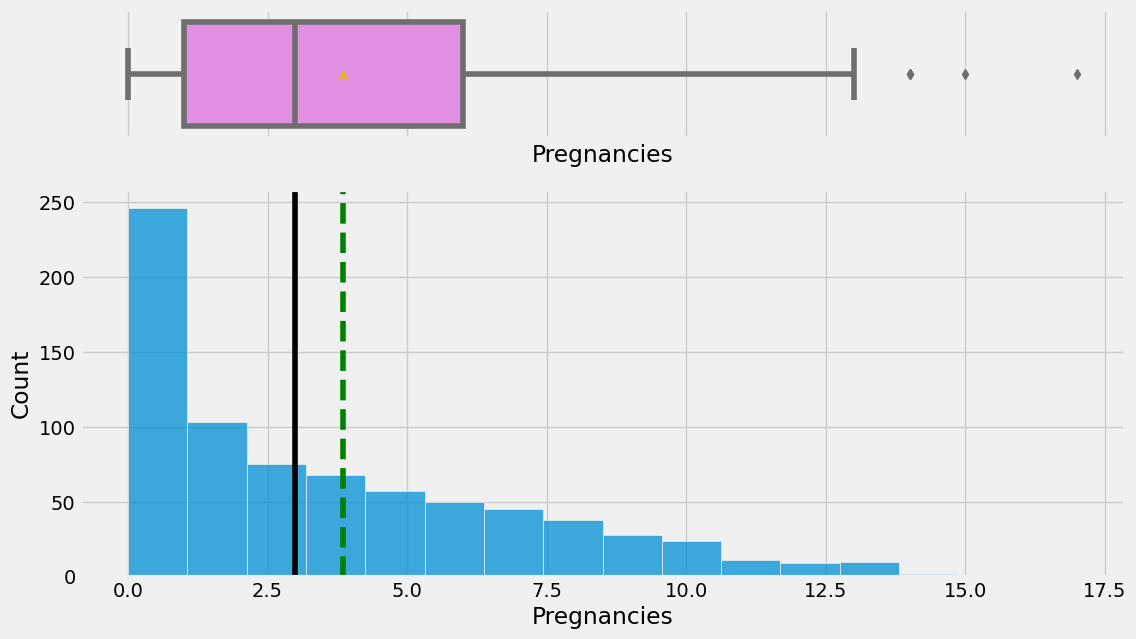

Univariates of  Glucose


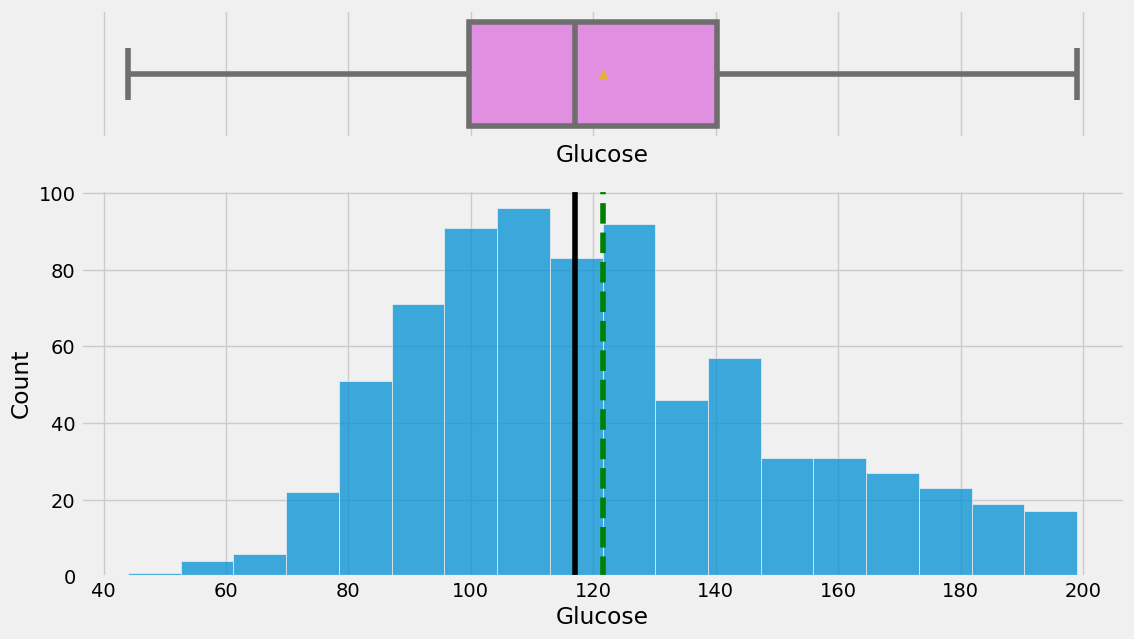

Univariates of  BloodPressure


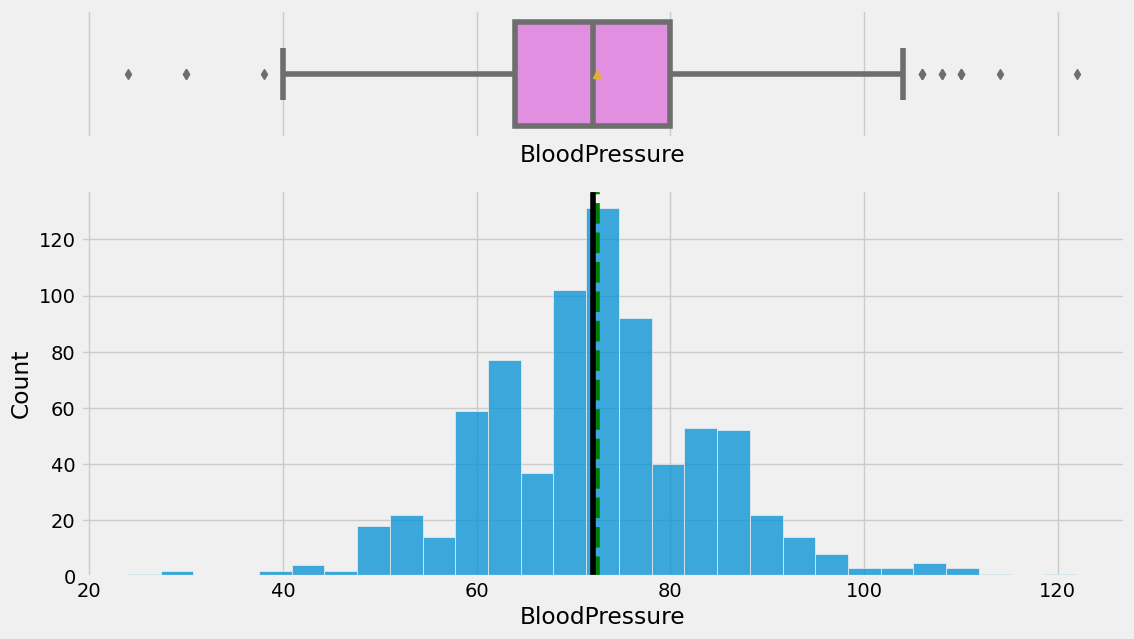

Univariates of  SkinThickness


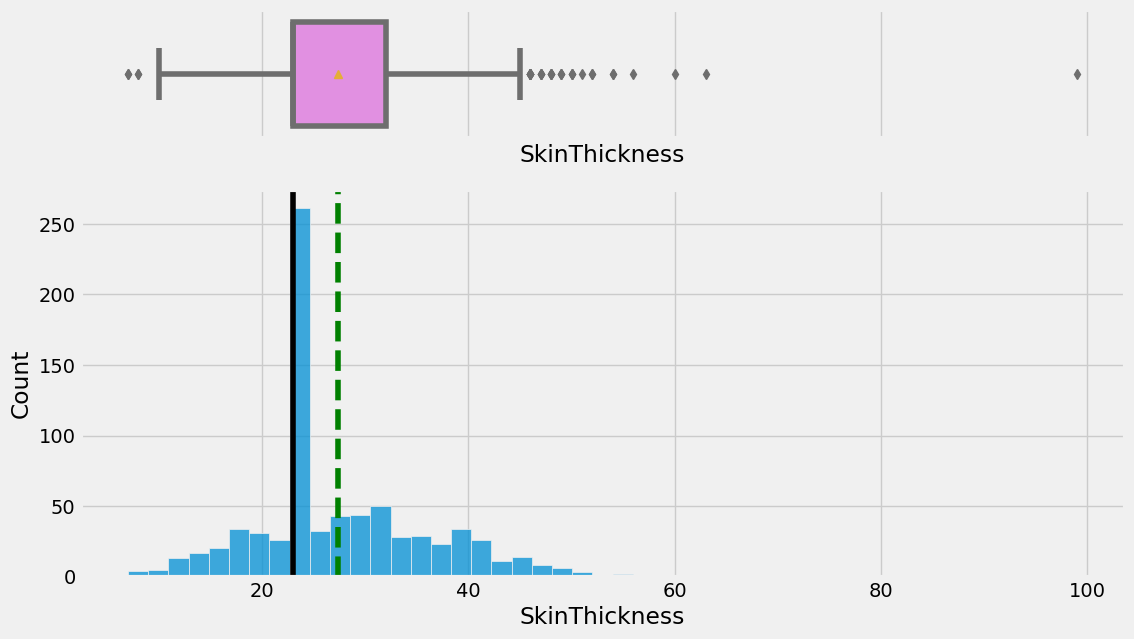

Univariates of  Insulin


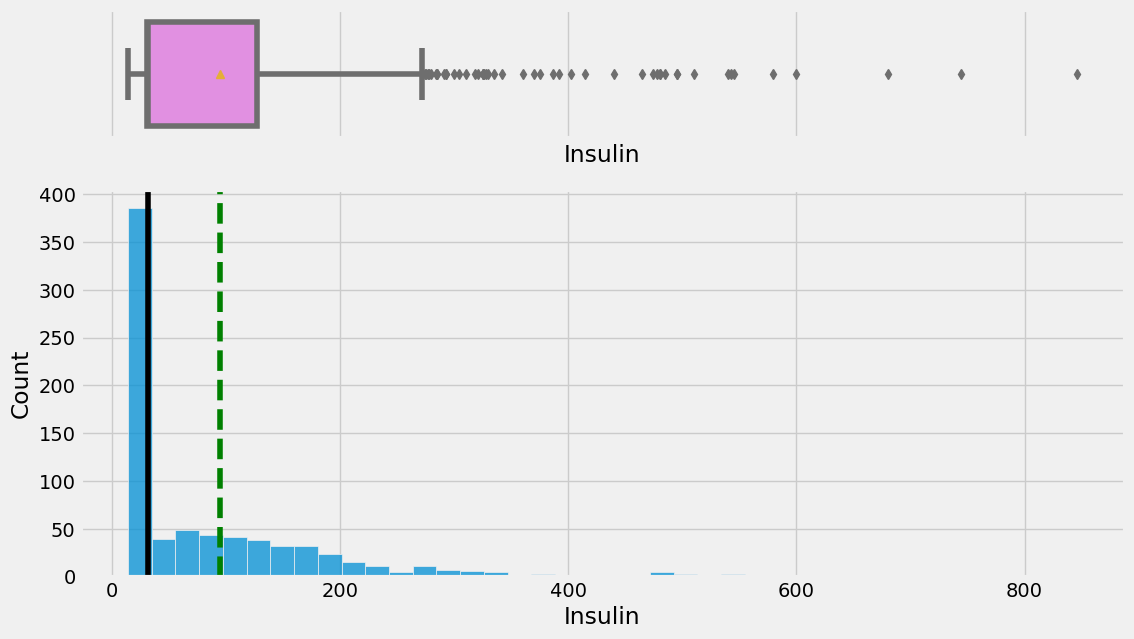

Univariates of  BMI


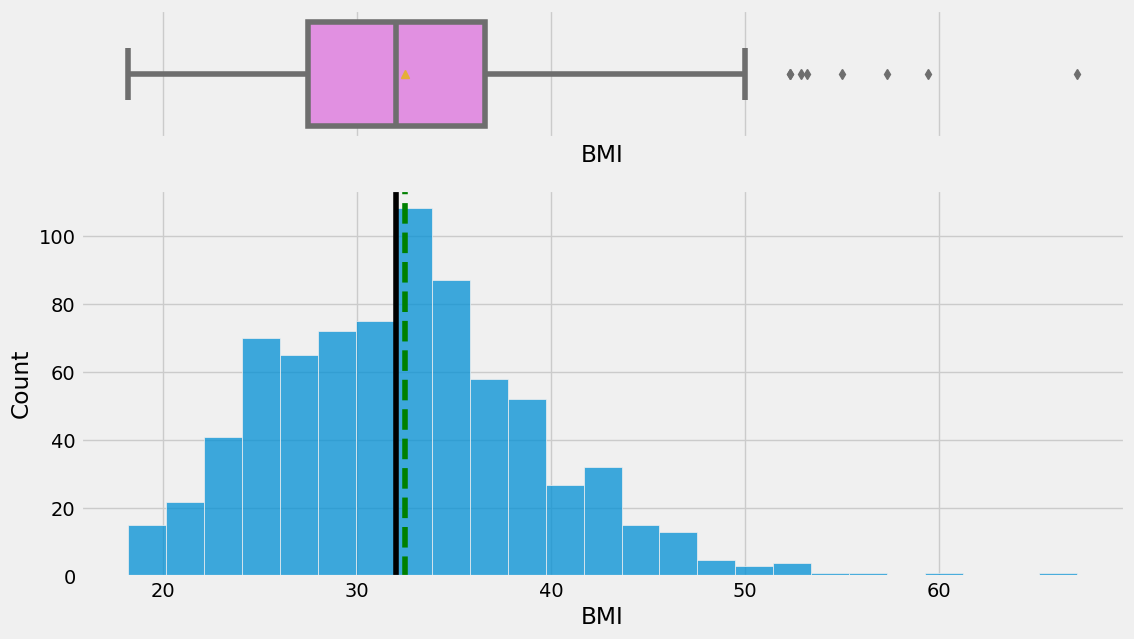

Univariates of  DiabetesPedigreeFunction


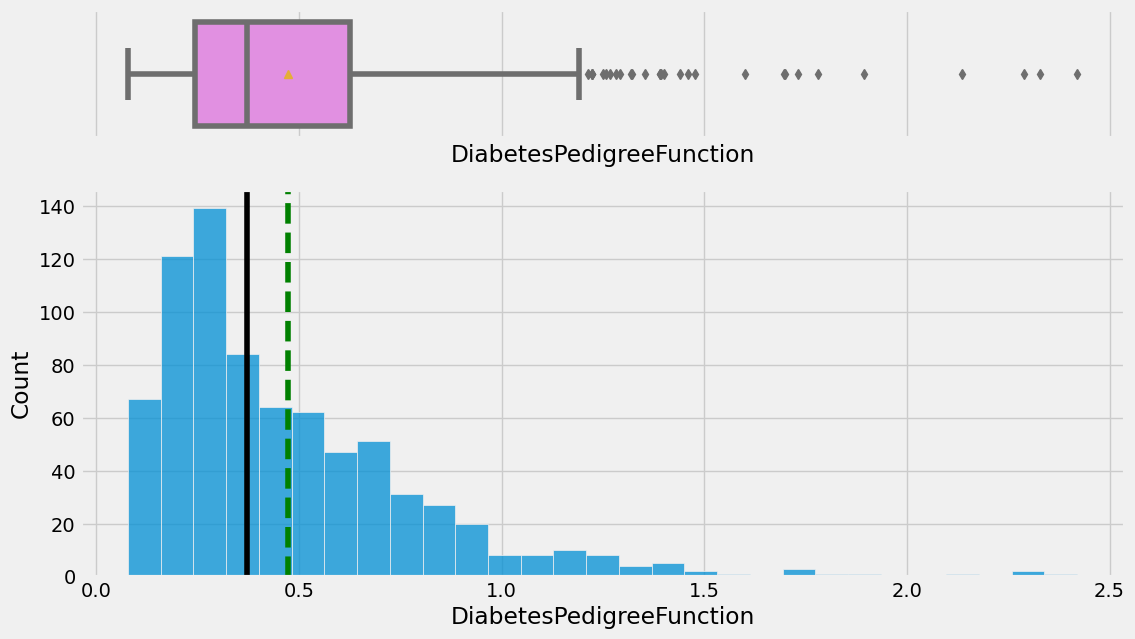

Univariates of  Age


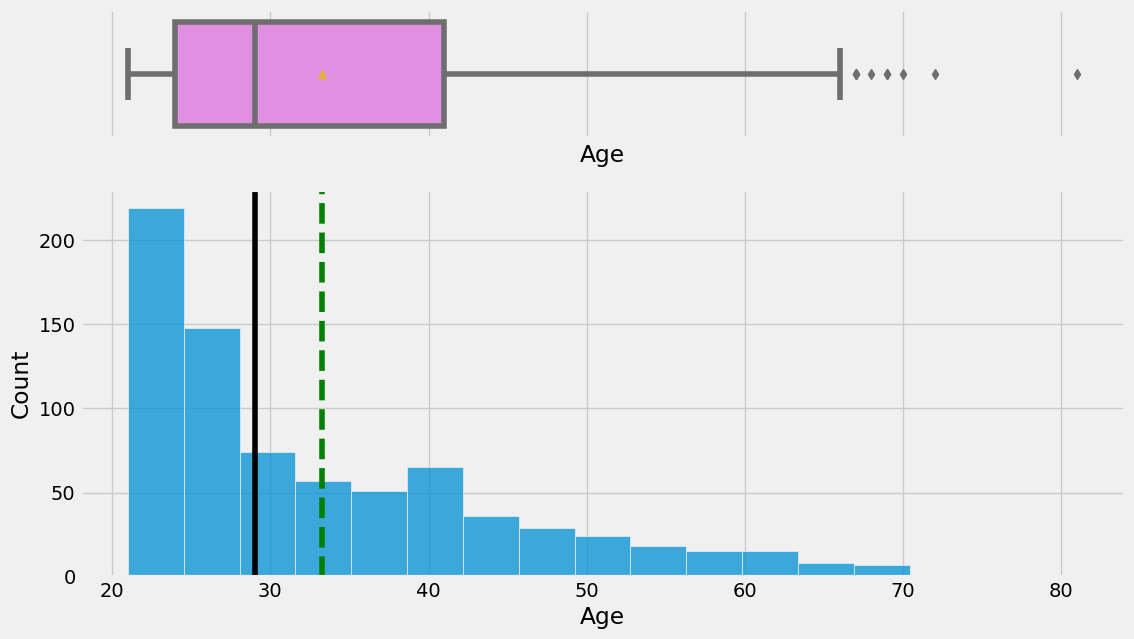

Univariates of  Outcome


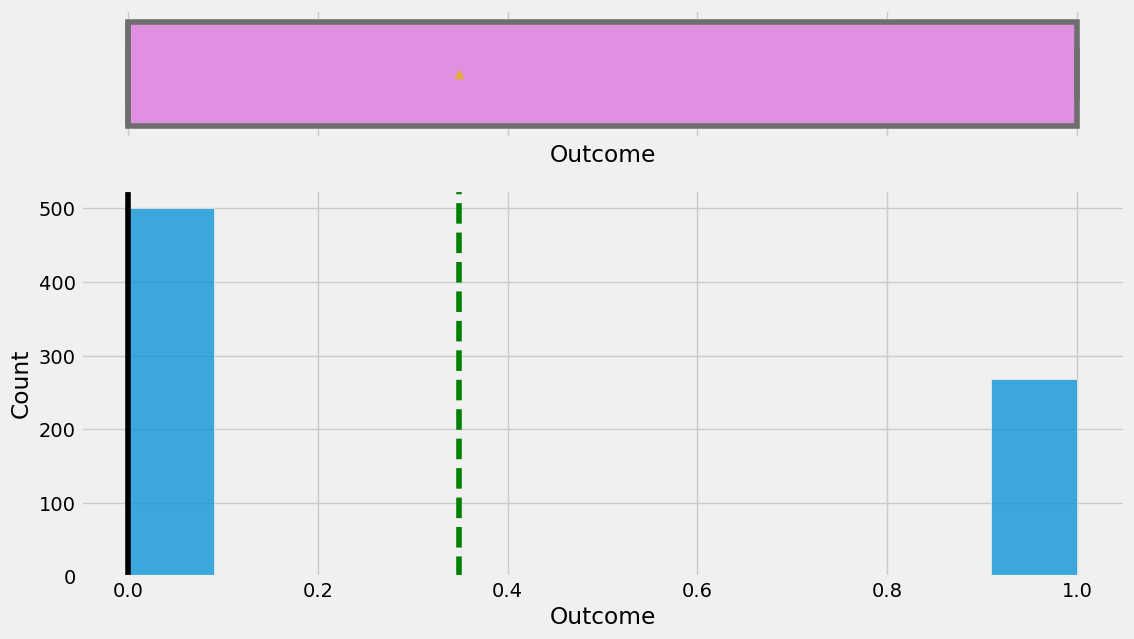

In [22]:
for col in df.select_dtypes(exclude='O').columns:
    boxpolot_histplot(data=df, feature=col)

**Observations**
1. Pregnancies has some suspect outliers which have to be looked upon
2. Skin thickness also has some suspect outliers which need to be taken care of 
3. Insulin is highly right skewed aand may need to be engineered
4. Diabetes pedigree function is also highly right skewed and needs to be engineered.
5. Outcome is highly imbalanced and may need balancing.

##### BIVARIATES-NUMERICAL vs CATEGORICAL

In [23]:
def catnums(data, feature1, feature2):
    print("Bivariate Barchart between {0} and {1}".format(feature1, feature2))
    data.groupby(feature1)[feature2].mean().plot(kind='bar',color='orange')
    plt.show()

Bivariate Barchart between Outcome and Pregnancies


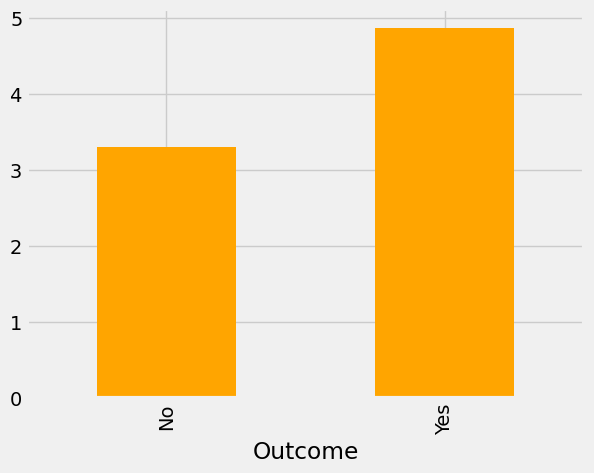

Bivariate Barchart between Outcome and Glucose


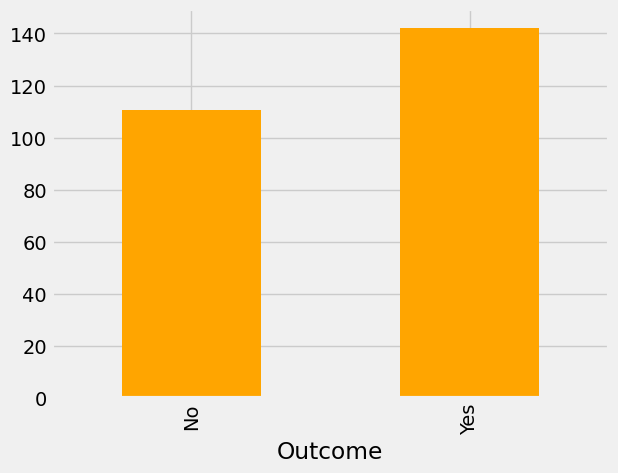

Bivariate Barchart between Outcome and BloodPressure


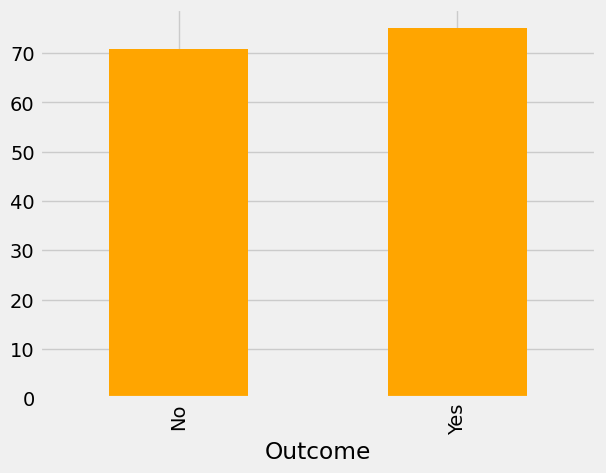

Bivariate Barchart between Outcome and SkinThickness


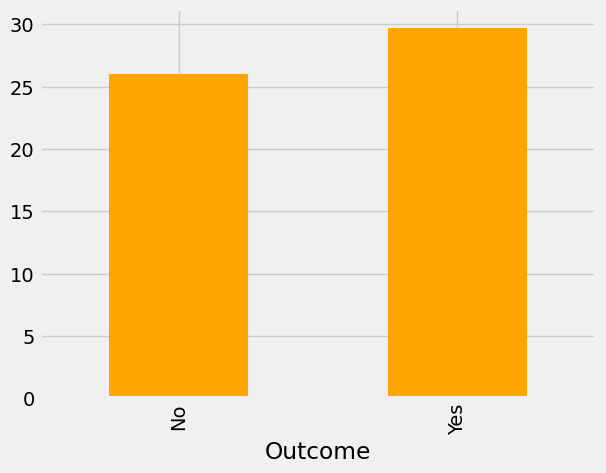

Bivariate Barchart between Outcome and Insulin


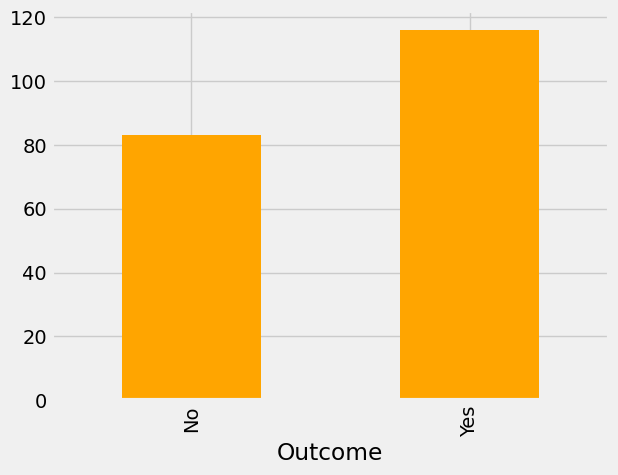

Bivariate Barchart between Outcome and BMI


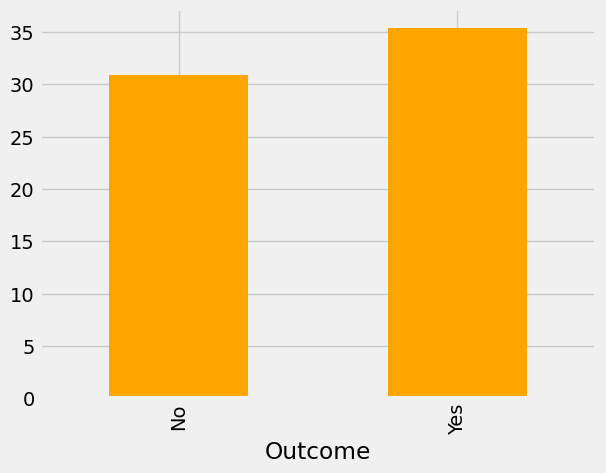

Bivariate Barchart between Outcome and DiabetesPedigreeFunction


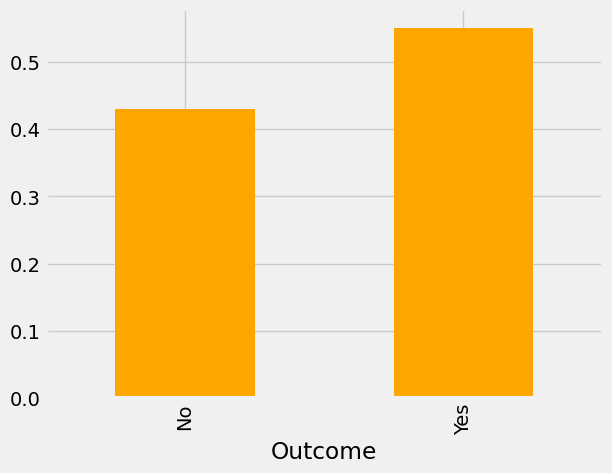

Bivariate Barchart between Outcome and Age


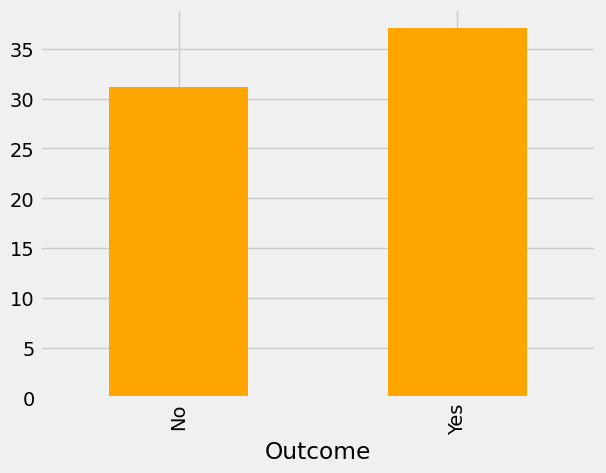

In [24]:
for col in data.select_dtypes(exclude='O').columns:
    catnums(data=data, feature1='Outcome', feature2=col)

**Observations**
Woman with higher pregnancies, higher diabetes predigree functions and Insulin use are more likely to be diabetic

##### BIVARIATES-NUMERICAL vs NUMERICAL

In [25]:
def lineplot_scatterplot(data, feature1, feature2):
    print("Bivariates between {0} and {1}".format(feature1, feature2))
    plt.figure(figsize=(16,7))
    plt.subplot(1,2,1)
    sns.lineplot(data=data, x=feature1, y=feature2, color='green')
    plt.subplot(1,2,2)
    sns.scatterplot(data=data, x=feature1, y=feature2, color='blue')
    plt.show()

Bivariates between Pregnancies and Pregnancies


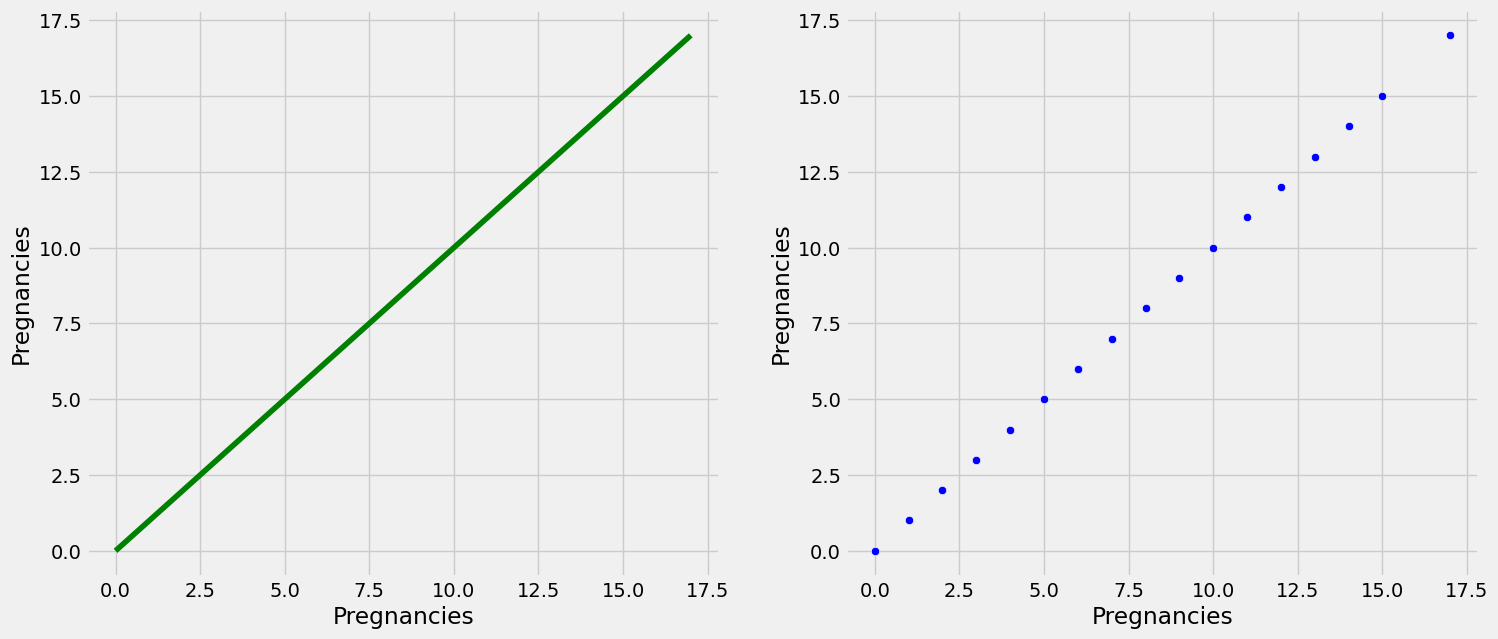

Bivariates between Pregnancies and Glucose


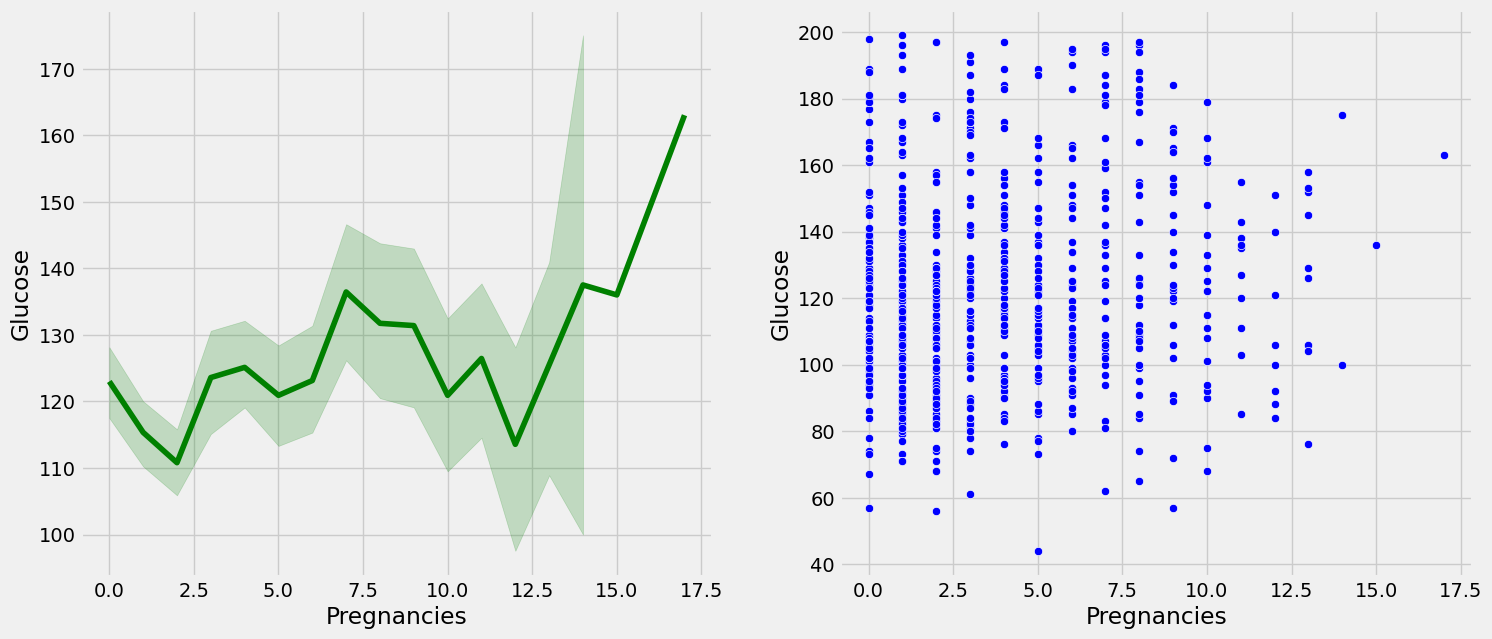

Bivariates between Pregnancies and BloodPressure


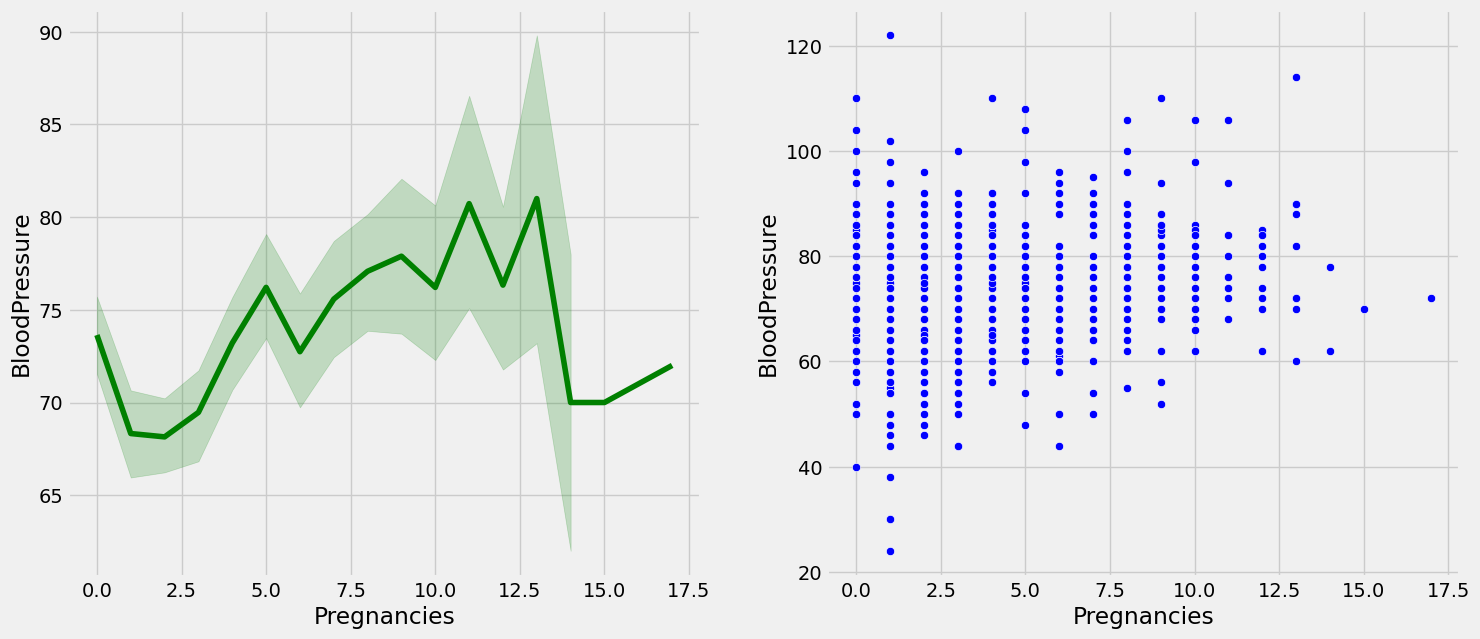

Bivariates between Pregnancies and SkinThickness


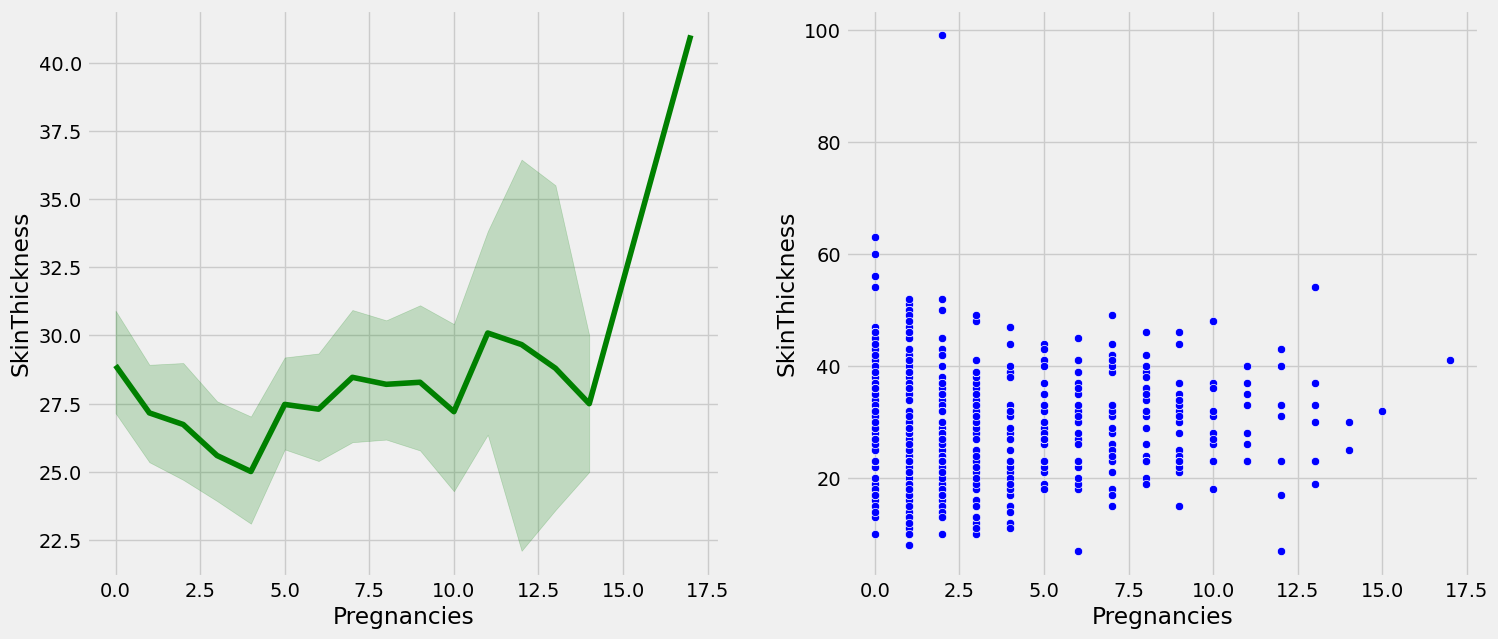

Bivariates between Pregnancies and Insulin


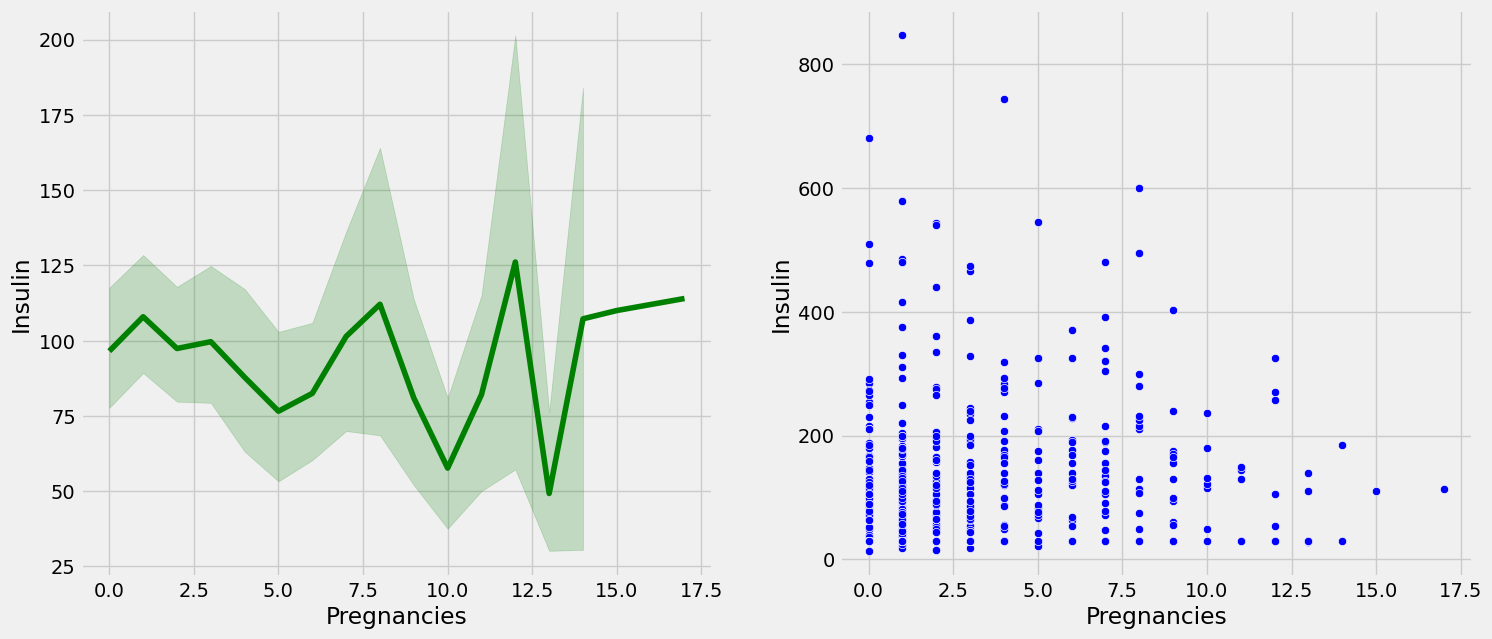

Bivariates between Pregnancies and BMI


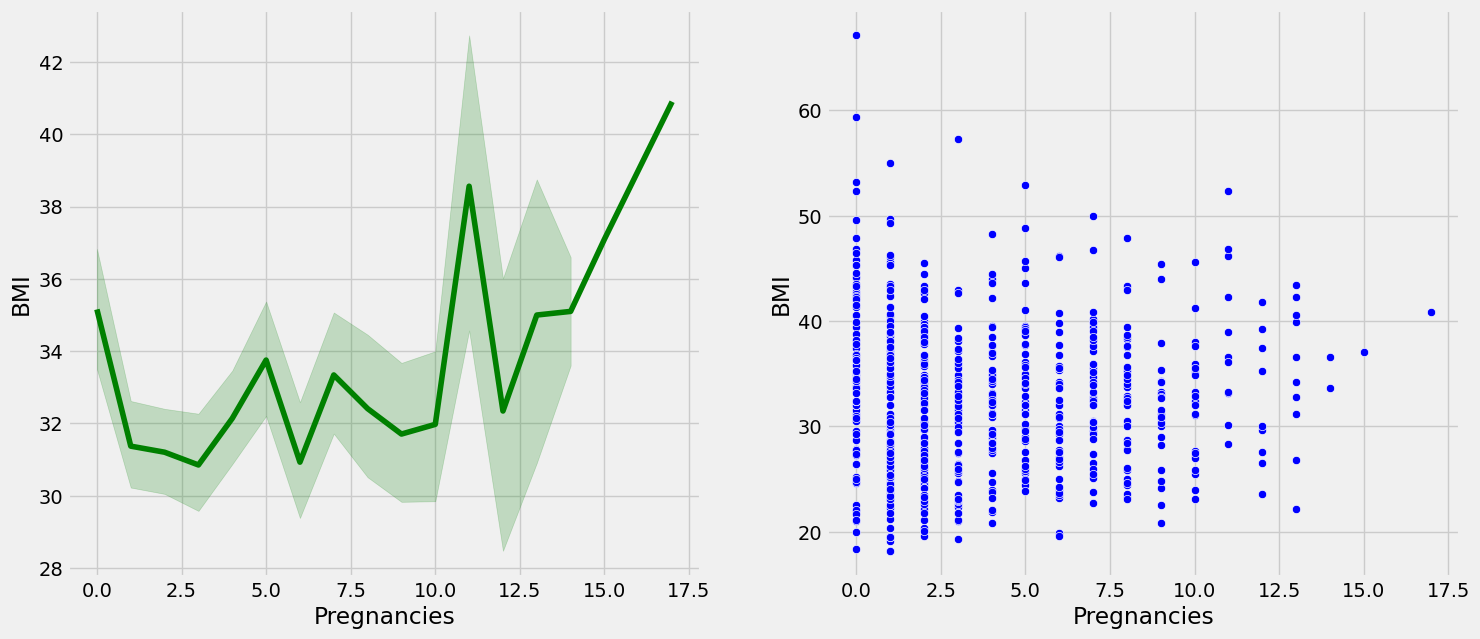

Bivariates between Pregnancies and DiabetesPedigreeFunction


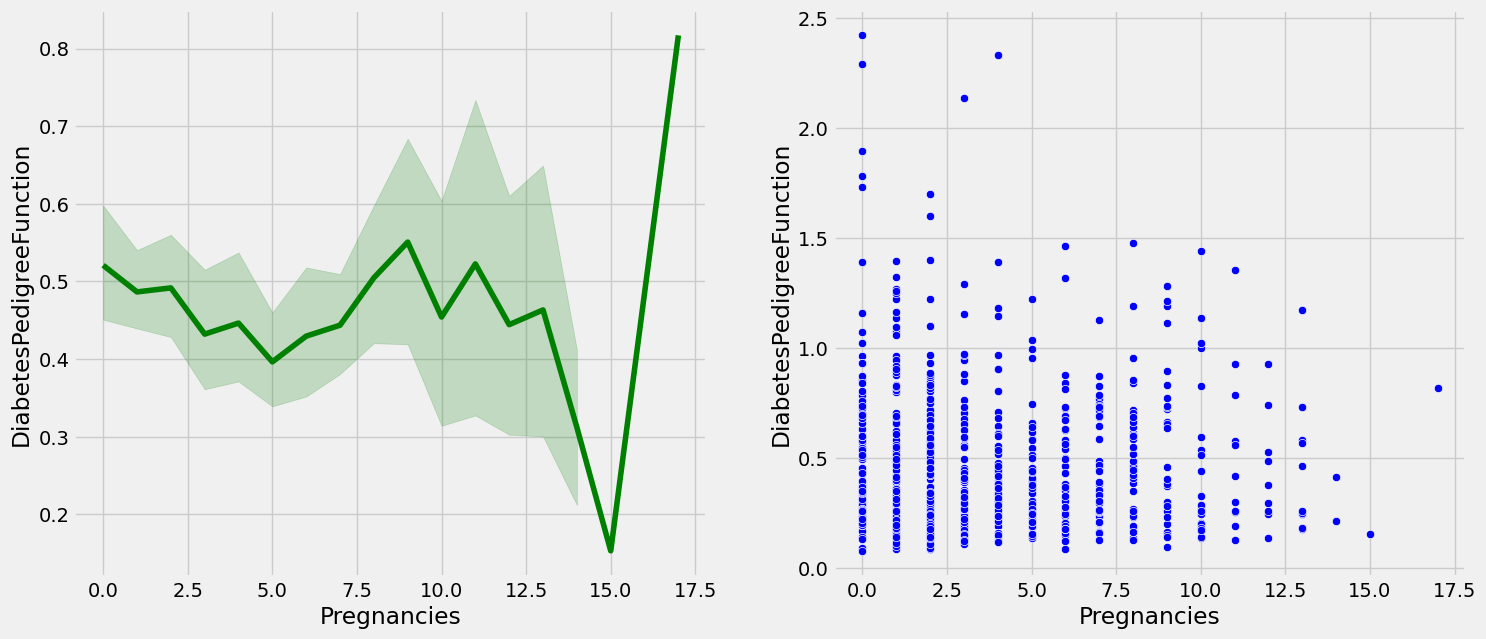

Bivariates between Pregnancies and Age


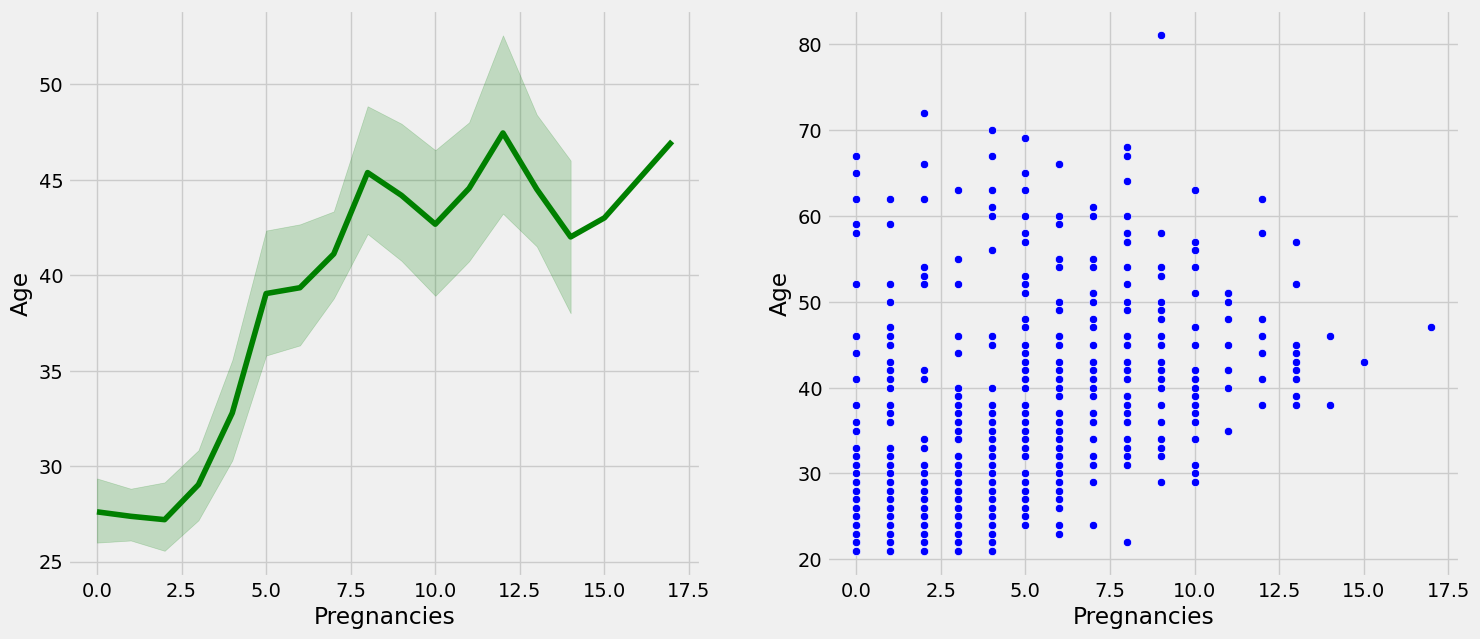

In [26]:
for col in data.select_dtypes(exclude='O').columns:
    lineplot_scatterplot(data=data, feature1='Pregnancies', feature2=col)
    
    

##### MULTIVARIATE CHARTS

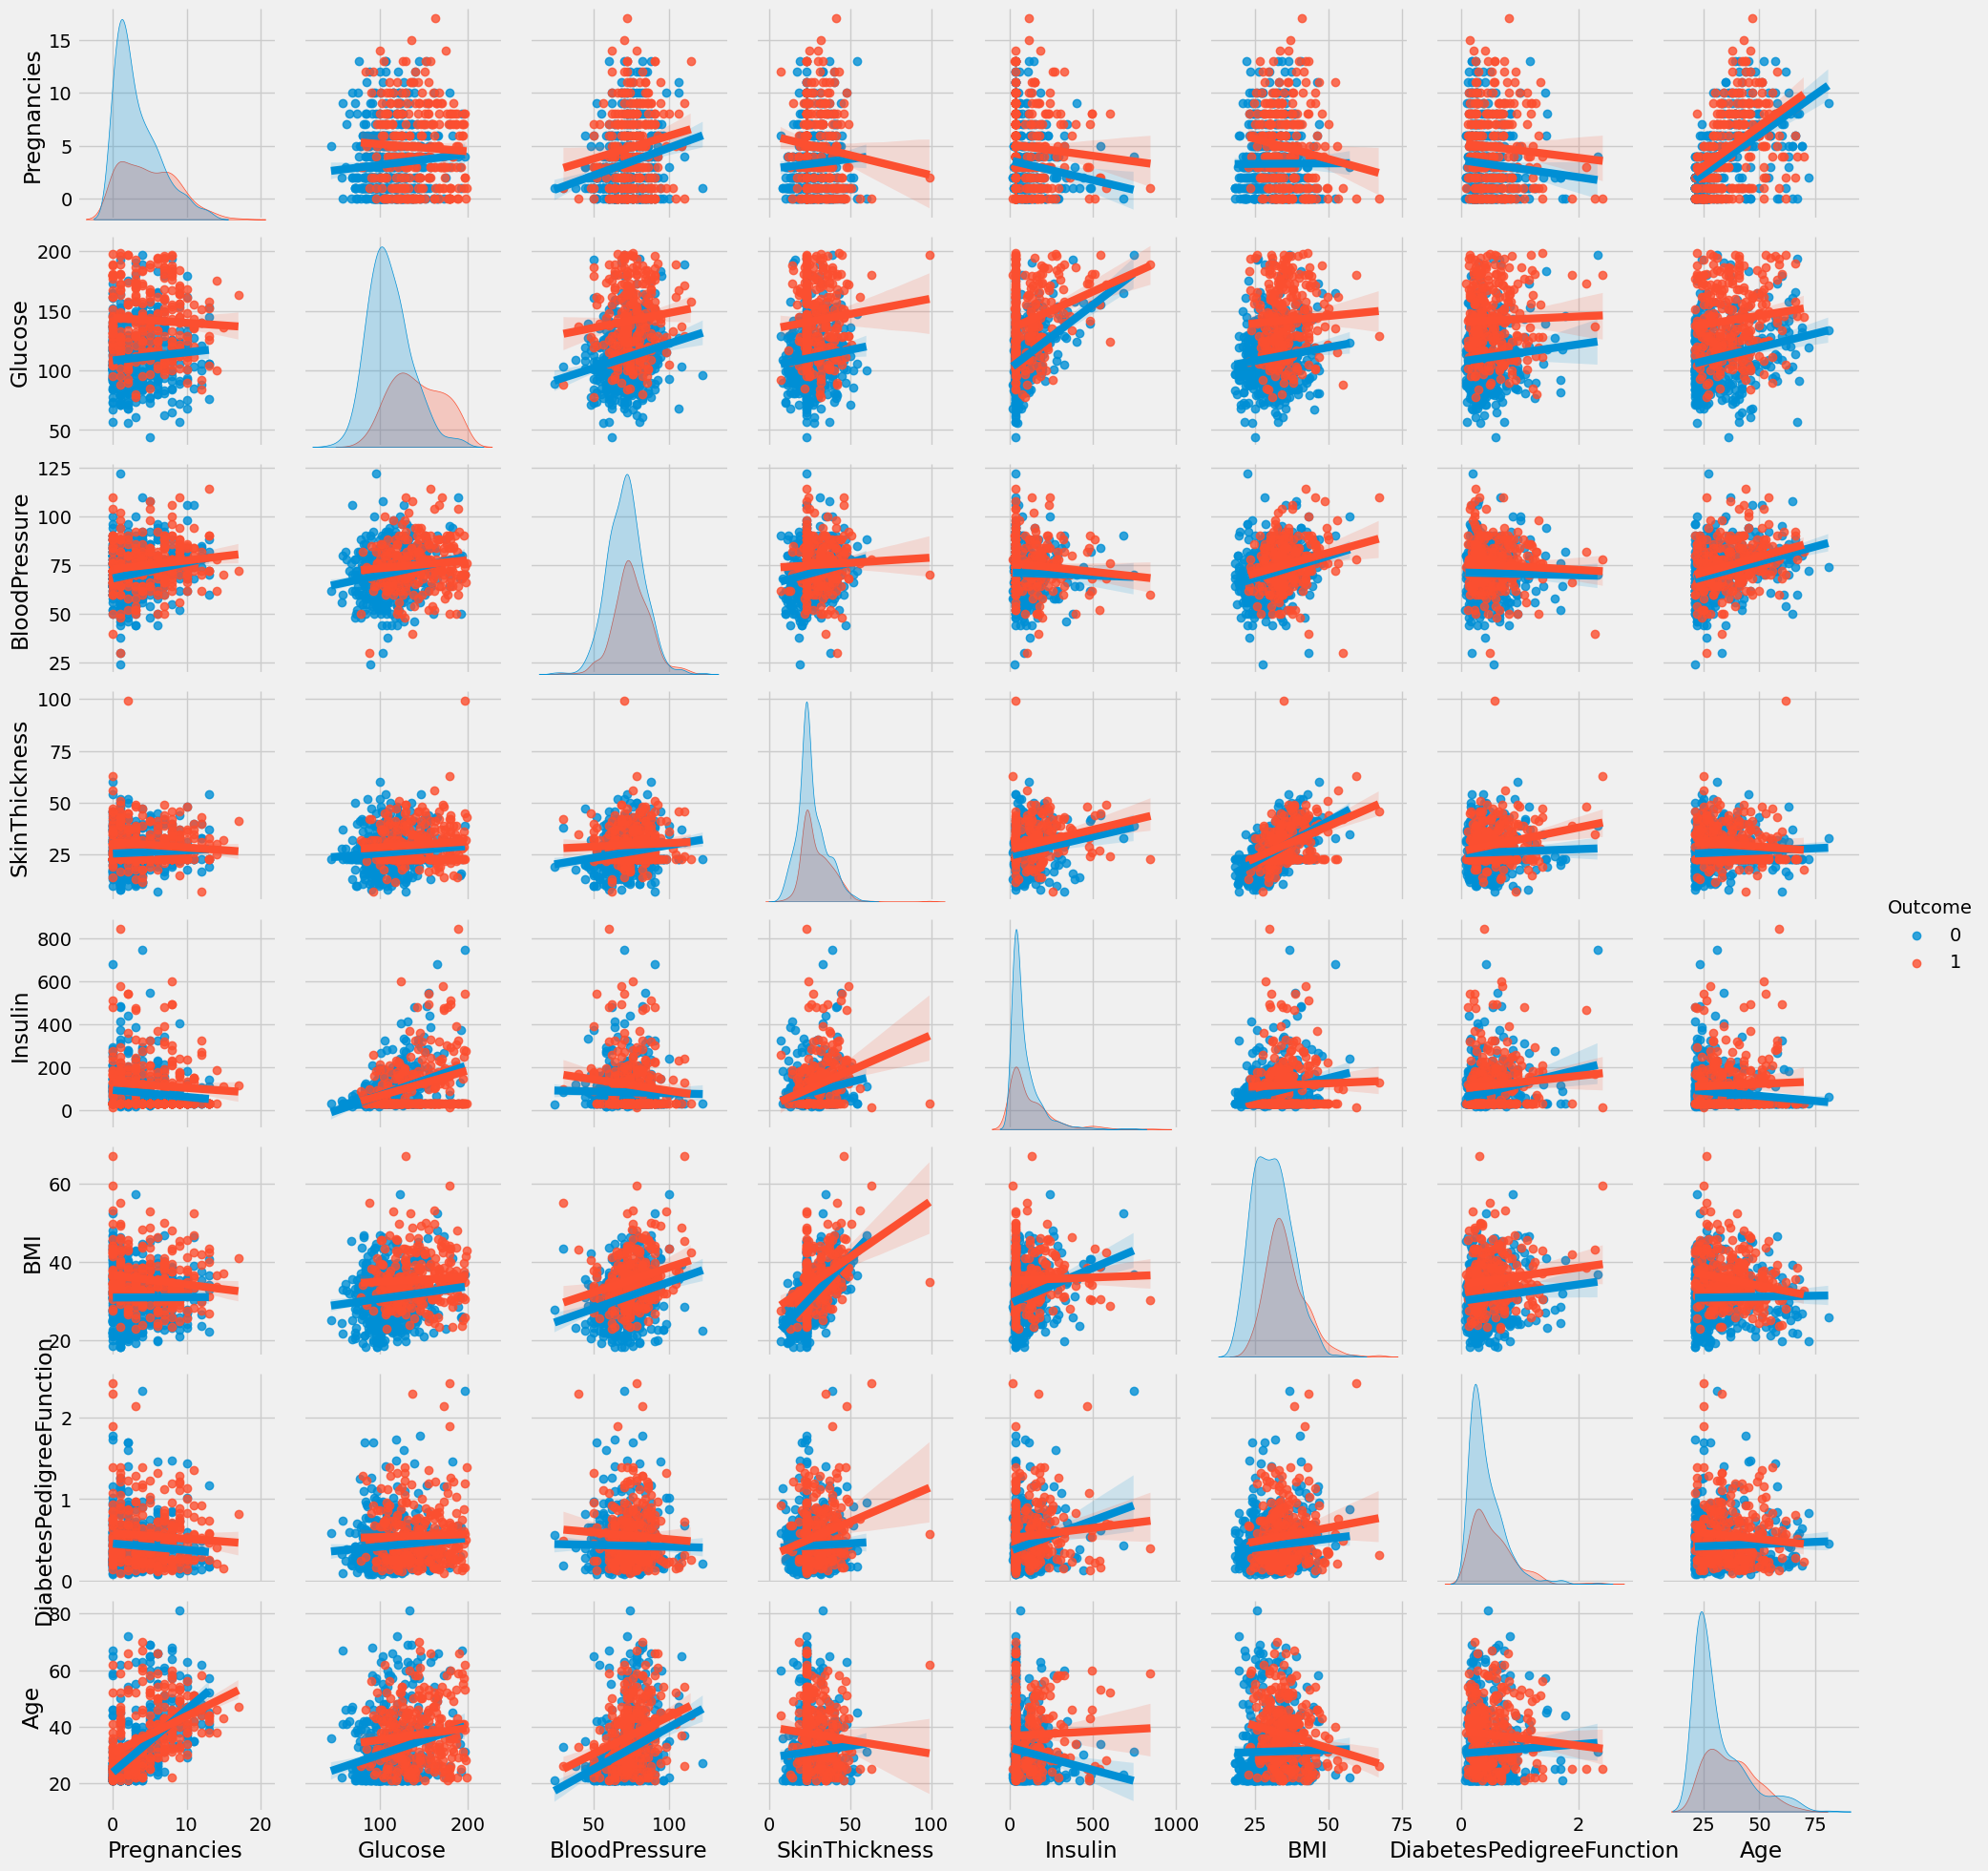

In [27]:
sns.pairplot(data=df, hue='Outcome', kind='reg')

##### Correlations and Heatmaps

In [28]:
df[df.columns[:]].corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.492782
BloodPressure               0.165723
SkinThickness               0.189065
Insulin                     0.148457
BMI                         0.312249
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

<AxesSubplot:>

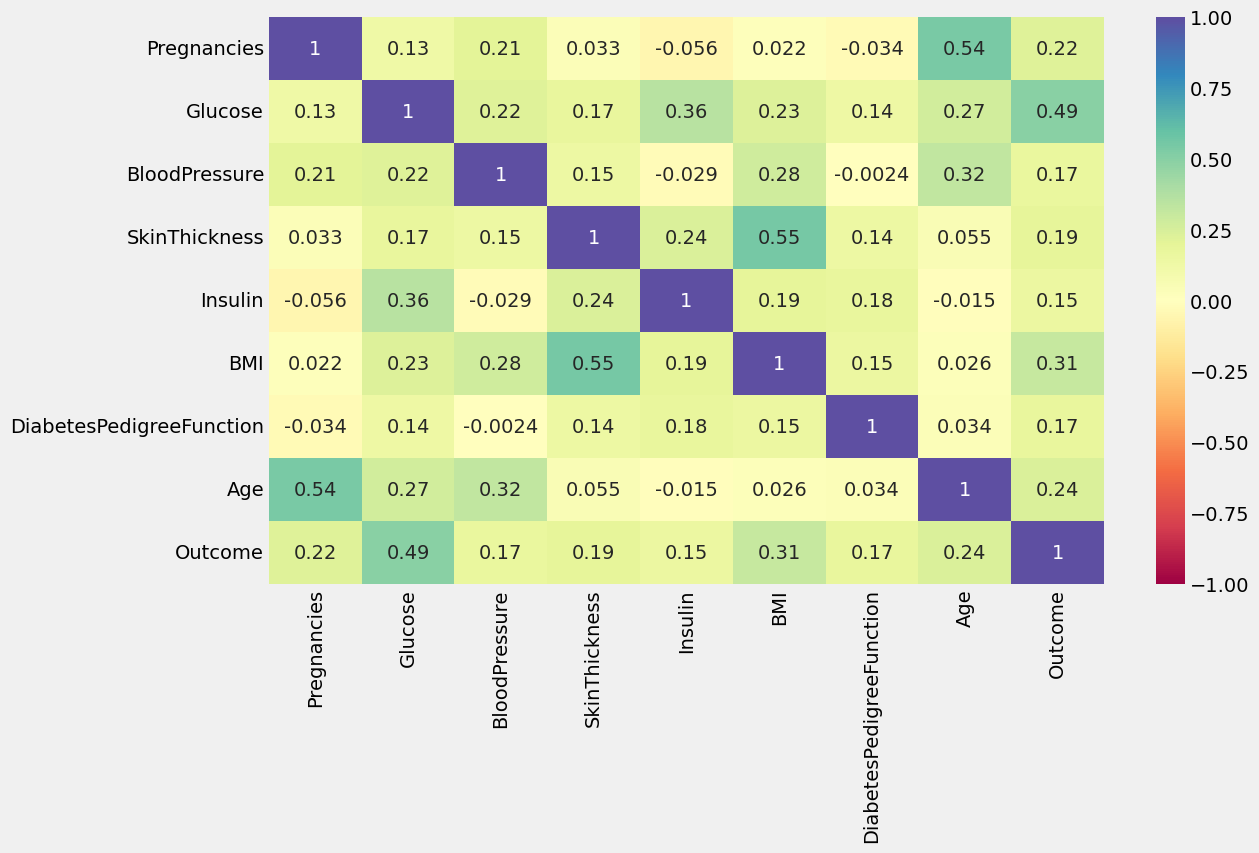

In [29]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)

**Observations**
Glucose and BMI seem to be strongest predictors of Diabetes

In [30]:
%%writefile eda.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)
st.title("The EDA Page")

def main():
    st.sidebar.subheader("Please choose the plot")
    data=pd.read_csv('data.csv')
    # drop the redundant column
    data=data.drop('Unnamed: 0', axis=1)
    # treat the nulls
    zerofiller=lambda x: x.replace(0, x.median())
    cols=data.columns[1:6]
    data[cols]=data[cols].apply(zerofiller, axis=0)
    #encode categoricals
    df=data.copy()
    d={'Yes':1, 'No':0}
    df['Outcome']=df['Outcome'].map(d)
    
    def histograms(data):
        st.subheader('Univariate Histogram')
        data.hist()
        plt.tight_layout()
        st.pyplot()
    def barchart(data, feature):
        st.subheader("Barchart of Categoricals")
        ax=sns.countplot(data=data, x=feature, color='green')
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
        st.pyplot()
        
    def heatmap(data):
        st.subheader("The Heatmap")
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)
        st.pyplot()
        
    plot=st.sidebar.selectbox('Choose Plot',('Histograms', 'Barchart', 'Heatmap'))
    if st.sidebar.button("PLOT"):
        if plot=='Histograms':
            histograms(df)
        if plot=='Barchart':
            barchart(data=df, feature='Outcome')
        if plot=='Heatmap':
            heatmap(data=df)
        
if __name__=='__main__':
    main()
        
        

    
    
    

Overwriting eda.py


# Step 4

In [31]:
# create a function for preprocessing 

def preprocess(df , label):
    x = df.drop(label,axis=1)
    y = df[label]
    from imblearn.over_sampling import SMOTE
    sm = SMOTE()
    x,y= sm.fit_resample(x,y)
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)
    return xtrain,xtest,ytrain,ytest

In [32]:
x_train,x_test,y_train,y_test = preprocess(df,'Outcome')

In [33]:
# scale the feature

sc = StandardScaler()
x_train=sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [34]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(700, 8) (300, 8) (700,) (300,)


**The data is now ready for modelling**

# Step 5 fit and evaluate various model

In [35]:
# function to print metrics
def print_metrics(ytest,ypred,model):
    print('Metrics for the model',model)
    print(' ')
    print("Accuracy score is ",accuracy_score(ytest,ypred))
    print(' ')
    print("recall score is ",recall_score(ytest,ypred))
    print(' ')
    print('precision score is',precision_score(ytest,ypred))
    print(' ')
    print('f1 score is', f1_score(ytest,ypred))
    print(' ')
    print(' Roc score is ',roc_auc_score(ytest,ypred))
    print(' ')
    print('Confusion matrix \n', confusion_matrix(ytest,ypred))
    print(' ')
    print('Classification report \n',classification_report(ytest,ypred))

In [36]:
def plot_metrics(clf,x_test,y_test,model):
    print('Metric Plots for model',model)
    plot_confusion_matrix(clf,x_test,y_test,labels=[0,1])
    print(' ')
    plot_roc_curve(clf,x_test,y_test)
    print(' ')
    plot_precision_recall_curve(clf,x_test,y_test)
    

In [37]:
# create and fit a KNN model
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
ypred=knn.predict(x_test)
print_metrics(y_test,ypred,'KNN')

Metrics for the model KNN
 
Accuracy score is  0.7833333333333333
 
recall score is  0.8066666666666666
 
precision score is 0.7707006369426752
 
f1 score is 0.7882736156351792
 
 Roc score is  0.7833333333333333
 
Confusion matrix 
 [[114  36]
 [ 29 121]]
 
Classification report 
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       150
           1       0.77      0.81      0.79       150

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



In [41]:
# lets select the best model on f1 score and optimize it

clfs={
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'Logregs' : LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random forest': RandomForestClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Gradientboosting': GradientBoostingClassifier(),
    'XGboost': XGBClassifier(),
    'SVM': SVC()
}

models_report=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score'])

for clf,clf_name in list(zip(clfs.values(),clfs.keys())):
    clf.fit(x_train,y_train)
    ypred=clf.predict(x_test)
    print('Fitting the model.....', clf_name)
    t={
        'model':clf_name,'accuracy':accuracy_score(y_test,ypred),
        'precision':precision_score(y_test,ypred),'recall': recall_score(y_test,ypred),
        'f1_score':f1_score(y_test,ypred)
    }
    models_report=models_report.append(t,ignore_index=True)
models_report=models_report.sort_values(by='f1_score',ascending=False)
models_report


Fitting the model..... KNN
Fitting the model..... NaiveBayes
Fitting the model..... Logregs
Fitting the model..... Decision Tree
Fitting the model..... Random forest
Fitting the model..... AdaBoost
Fitting the model..... Gradientboosting
Fitting the model..... XGboost
Fitting the model..... SVM


model  accuracy  precision    recall  f1_score
7           XGboost  0.826667   0.802469  0.866667  0.833333
6  Gradientboosting  0.820000   0.800000  0.853333  0.825806
4     Random forest  0.816667   0.798742  0.846667  0.822006
5          AdaBoost  0.806667   0.798701  0.820000  0.809211
8               SVM  0.806667   0.798701  0.820000  0.809211
0               KNN  0.783333   0.770701  0.806667  0.788274
3     Decision Tree  0.786667   0.790541  0.780000  0.785235
2           Logregs  0.750000   0.773723  0.706667  0.738676
1        NaiveBayes  0.703333   0.740157  0.626667  0.678700

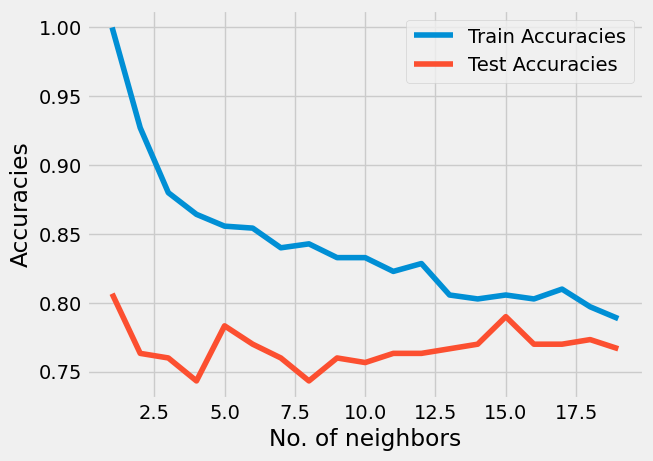

In [43]:
# lets try to optimize the KNN using a model complexity curve
neighbors = np.arange(1,20)
train_accuracies = np.empty(len(neighbors))
test_accuracies = np.empty(len(neighbors))


#enumarte along the neighbors

for i , k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    train_accuracies[i]=knn.score(x_train,y_train)
    test_accuracies[i] = knn.score(x_test,y_test)
    
    
# plot the model complexity curves

plt.plot(neighbors,train_accuracies,label='Train Accuracies')
plt.plot(neighbors,test_accuracies,label='Test Accuracies')
plt.legend()
plt.xlabel('No. of neighbors')
plt.ylabel('Accuracies')
plt.show()


In [48]:
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test)

In [53]:
param={
    'n_estimators':[100,150,200,250],
    'min_samples_leaf':range(1,5,1),
    'min_samples_split':range(2,20,2),
    'max_depth':[2,4,'auto'],
    'max_features':['sqrt','log2'],
    'criterion':['gini','entropy']
}
n_folds=3
cv = GridSearchCV(estimator = rfc,param_grid=param,cv=n_folds,n_jobs=1,verbose=3,return_train_score=False)
cv.fit(x_train,y_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.812 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.777 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.765 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.777 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.794 total time=   0.0s
[CV 1/3] END criterion=

[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.760 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.777 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.782 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.760 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.794 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.791 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.777 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.785 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.738 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.782 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.730 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.781 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.747 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.773 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.777 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.760 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.785 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.751 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=3, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.761 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.760 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.785 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.785 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.790 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.782 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.742 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.730 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.747 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.778 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.751 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.774 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.742 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.738 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.791 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.760 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.808 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.747 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_sam

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.781 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.774 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.721 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.778 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.730 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=3, m

[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.781 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.799 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.790 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.738 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_sam

[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.774 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.798 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.785 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, m

[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.816 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.777 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.791 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.791 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, m

[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.816 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_sam

[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.791 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.751 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.820 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, m

[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.821 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.816 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_sam

[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=3, m

[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.808 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.808 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.760 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, m

[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.755 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.798 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.803 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_sam

[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=250;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, m

[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.808 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_sam

[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=250;, score=0.803 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=250;, score=0.773 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, m

[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.798 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_sam

[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=0.803 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=0.768 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=3, m

[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.777 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_sam

[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.760 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=0.808 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=0.768 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=14, n_estimators=100;, score=0.816 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, m

[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1

[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=14, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_

[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2

[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=14, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_

[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3

[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_

[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4

[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=sqrt, min_samples_

[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1

[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=16, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=16, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=16, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=18, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=18, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=18, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_

[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2

[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=18, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_

[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_

[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4

[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=auto, max_features=log2, min_samples_

[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.747 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.765 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.764 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, 

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.765 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.777 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.777 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.768 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.791 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, 

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.794 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.765 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.790 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.803 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.773 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.777 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.756 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, 

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.768 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.791 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.781 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.799 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.781 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.769 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.790 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.769 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=sqrt, 

[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.742 total time=   0.3s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.765 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.747 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.742 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.782 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, 

[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.778 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.738 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.752 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.765 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.742 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.751 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, 

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.782 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.742 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.786 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.751 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.765 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.747 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.794 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.782 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.730 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, 

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.730 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.790 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.761 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=0.725 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_sa

[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.765 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.721 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.786 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=200;, score=0.755 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=2, max_features=log2, 

[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.808 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.807 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.803 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=0.773 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.807 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.799 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.773 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.815 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, 

[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.816 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=0.807 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.812 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.824 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.795 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.781 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=150;, score=0.820 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=0.781 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, 

[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.815 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.808 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.768 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.816 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_sa

[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.755 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.811 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=150;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, 

[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.812 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.807 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.821 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=250;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_sa

[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.807 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.803 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.777 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=0.803 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.795 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=0.790 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=sqrt, 

[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.803 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.808 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=0.764 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_sa

[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.777 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=0.807 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.803 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.764 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=0.825 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, 

[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.799 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.808 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.777 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.798 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_sa

[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.811 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.795 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.773 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.825 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=0.773 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, 

[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.816 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.764 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=0.815 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_sa

[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.812 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.764 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=0.808 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, 

[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.777 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.791 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.768 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=0.811 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.803 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_sa

[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.799 total time=   0.1s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.773 total time=   0.1s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.803 total time=   0.1s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.768 total time=   0.2s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=0.803 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=4, max_features=log2, 

[CV 3/3] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=18, n_estimators=250;, score=0.798 total time=   0.2s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqr

[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_featur

[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqr

[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_featur

[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqr

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_featur

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqr

[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_featur

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_featur

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=2, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_featur

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=3, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_featur

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log

[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=250;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=auto, max_features=log2, min_samples_leaf=4, min_samples_split=14, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=auto, max_featur

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 'auto'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 20, 2),
                         'n_estimators': [100, 150, 200, 250]},
             verbose=3)

In [55]:
cv.best_score_

0.8071176161304917

In [56]:
cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_split=18, n_estimators=250)

In [58]:
rfc_tuned=RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_split=18, n_estimators=250)
#cv.bestestimator
rfc_tuned.fit(x_train,y_train)
y_pred=rfc_tuned.predict(x_test)
print_metrics(y_test,y_pred,'RandomForest')

Metrics for the model RandomForest
 
Accuracy score is  0.8033333333333333
 
recall score is  0.8266666666666667
 
precision score is 0.7898089171974523
 
f1 score is 0.8078175895765471
 
 Roc score is  0.8033333333333333
 
Confusion matrix 
 [[117  33]
 [ 26 124]]
 
Classification report 
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       150
           1       0.79      0.83      0.81       150

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300



In [59]:
# evaluation of model

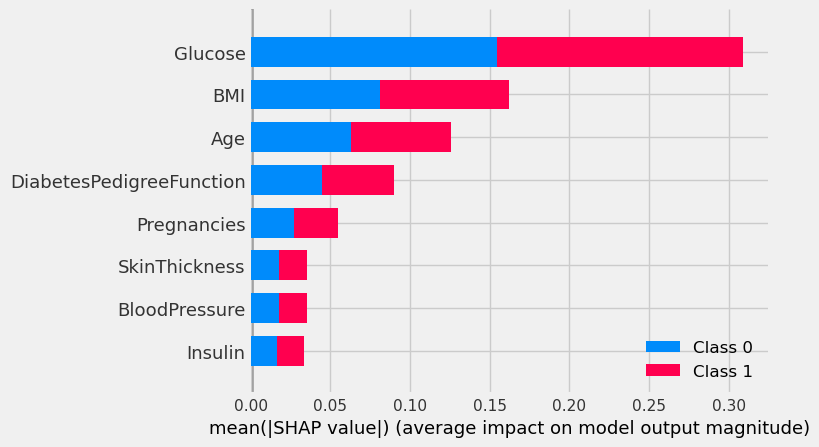

In [60]:
import shap 
x=df.drop('Outcome',axis=1)
value=shap.TreeExplainer(rfc).shap_values(x_test)
shap.summary_plot(value,x_train,plot_type='bar',feature_names=x.columns)

# Step 8 : Pickle and save the model as a pipeline|

Metric Plots for model Pipeline
 
 


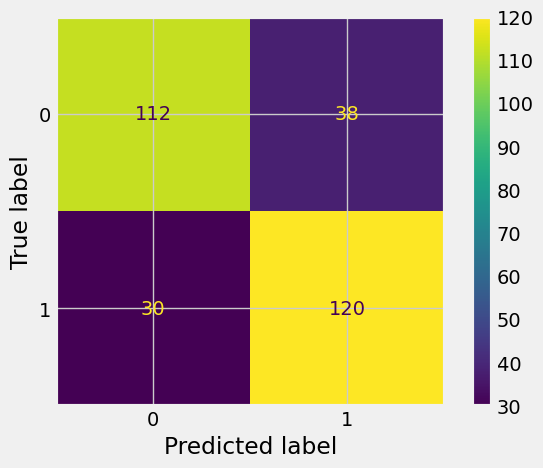

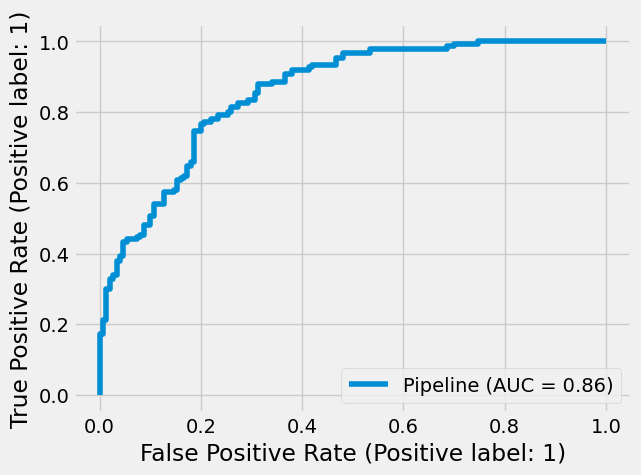

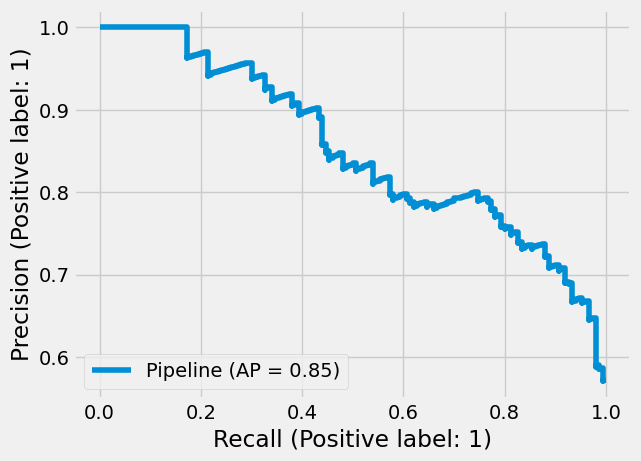

In [61]:
#Step 8 : Pickle and save the model as a pipeline
from sklearn.pipeline import Pipeline
sc=StandardScaler()
rfc_tuned=rfc_tuned
steps=[('scaler',sc),('rfc_tuned',rfc_tuned)]
pipeline=Pipeline(steps)
x_train,x_test,y_train,y_test=preprocess(df,label='Outcome')
pipeline.fit(x_train,y_train)
ypred=pipeline.predict(x_test)
plot_metrics(pipeline,x_test,y_test,'Pipeline')



In [65]:
#save the pipelines as pickle file 
import pickle
model=open('rfc.pickle','wb')# write binary file 
pickle.dump(pipeline,model)
model.close()

# Step 9: Deploy the model as a streamlit file

In [85]:
%%writefile app.py
import streamlit as st
st.title('Medical Diagnostic web app')
st.subheader("Is the patient Diabetic?")


#steps
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

import streamlit as st

# Load the pickeled model

model=open('rfc.pickle','rb')
clf=pickle.load(model)
model.close()




# step2: Get the input from the front end user
pregs=st.number_input('Pregnancies',0,17,0)
glucose=st.slider('Glucose',40,200,40)
bp=st.slider('BloodPressure',20,140,20)
skin=st.slider('SkinThickness',7.0,99.0,7.0)
insulin=st.slider('Insulin',14,850,14)
bmi=st.slider('BMI',18,67,18)
dpf=st.slider('DiabetesPedigreeFunction',0.05,2.5,0.05) 
age=st.slider('Age',20,90,20)



# step3: Collect the front end user input as model input data

data={
    'Pregnancies':pregs,
    'Glucose':glucose,
    "BloodPressure":bp,
    'SkinThickness':skin,
    'Insulin':insulin,
    'BMI':bmi,
    'DiabetesPedigreeFunction':dpf,
    'Age':age}

input_data=pd.DataFrame([data])

# step4: Get the prediction and print the result

preds=clf.predict(input_data)[0]
if st.button('Predict'):
    if preds==1:
        st.error('Diabetic')
    if preds==0:
        st.success('Non Diabetic')

Overwriting app.py
